ModuleNotFoundError: No module named 'solution_guidance'

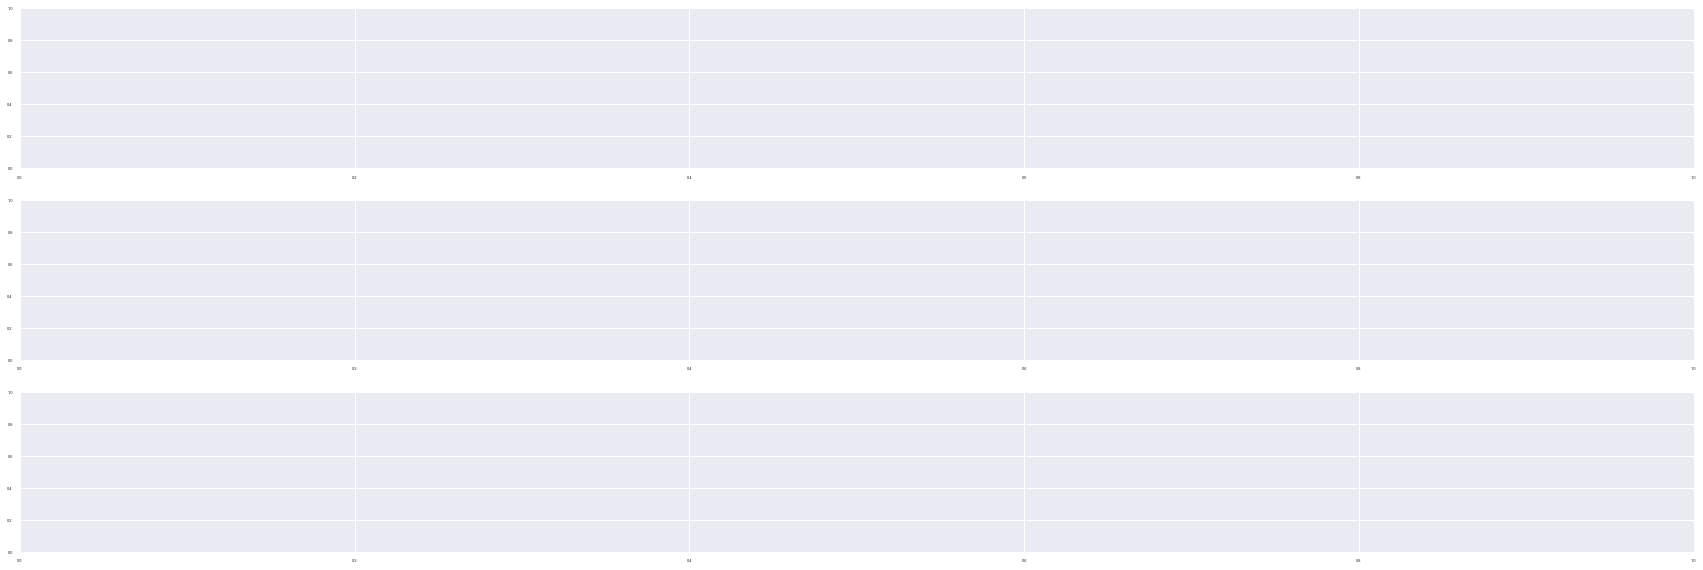

In [2]:
#!/usr/bin/env python
"""
Runs the functions for the final case study solution
"""

import os
import sys
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns
##################################################################################
## Data visualisation settings
##################################################################################
plt.style.use('seaborn')

#%matplotlib inline
'''
SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16
'''

SMALL_SIZE = 4
MEDIUM_SIZE = 5
LARGE_SIZE = 6
'''
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title
'''
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)   # fontsize of the figure title

#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
# Set up the matplotlib figure
f, axs = plt.subplots(3,1,figsize=(30, 10))

##################################################################################


from solution_guidance.cslib import fetch_data,convert_to_ts,fetch_ts,engineer_features
from capstone_project_sba_lib.capstone_project_sba_lib import print_data_summary

COLORS = ["darkorange","royalblue","slategrey"]

In [ ]:


if __name__ == "__main__":
    run_start = time.time() 
    data_dir = os.path.join("data","cs-train")
    print("...fetching data")

    ts_all = fetch_ts(data_dir,clean=False)
    #ts_all = fetch_ts(data_dir,clean=True)
    
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("... load time:", "%d:%02d:%02d"%(h, m, s))
    
    print("{}\nDATA LOADED (number of lines, number of columns)\n{}".format("-"*35,"-"*35))
    for key,item in ts_all.items():
        print(key,item.shape)
        
    data_ori = pd.DataFrame()
    engineer_feat = pd.DataFrame()
    
    for country,df in ts_all.items():
        if country not in ['all']:
        #if country in ['all','united_kingdom']:
            tmp = df
            tmp['country'] = country
            data_ori = data_ori.append(tmp)
                        
            X,y,dates = engineer_features(df)
            X['country'] = country
            X['dates'] = dates
            X['next_month_target_revenue'] = y
            '''print(X.shape)
            print (X.head(n=5))
            print (X.tail(n=5))
            print(y.size)
            print (y[:5])
            print (y[-5:])'''
            engineer_feat = engineer_feat.append(X)
    
    data_ori.reset_index(inplace=True, drop=True) 
    engineer_feat.reset_index(inplace=True, drop=True)
    engineer_feat = engineer_feat[['country','dates','recent_invoices','recent_views','previous_7','previous_14','previous_28','previous_70','previous_year','next_month_target_revenue']]
    
    print("{}\nORIGINAL DATAFRAME\n{}".format("-"*35,"-"*35))
    print(data_ori.shape)
    print (data_ori.head(n=10))
    #print (data_ori.tail(n=10))
    #print_data_summary(data_ori)
    #print_data_summary(data_ori)
    
     
    print("{}\nENGINEER FEATURES DATAFRAME\n{}".format("-"*35,"-"*35))
    print(engineer_feat.shape)
    print (engineer_feat.head(n=10))
    #print (engineer_feat.tail(n=10))
    print_data_summary(engineer_feat)
       
    print("\n{}\nEXPLORATORY DATA ANALYSIS\n{}".format("-"*50,"-"*50))
 
    print("\n{}\nNumber of 'days' per country\n{}".format("-"*50,"-"*50)) 
    df_pivot = pd.pivot_table(engineer_feat, index= "country", values="dates",aggfunc='count').round(3)
    df = df_pivot.sort_values(by='dates', ascending=False)
    print(df)
    
    #ax.bar(langs,students)
    #ax.bar(df_pivot[country].tolist(),df_pivot[dates].tolist())
    df.plot(kind='bar',ax=axs[0,0],legend=False,title='Days counts')
    #plt.show()
    #sns.countplot(x='dates',data=engineer_feat, hue='country',ax=axs[0]).set_title("dates")
    
    print("\n{}\nNumber of not null 'previous_year' lines per country\n{}".format("-"*50,"-"*50)) 
    df_pivot = pd.pivot_table(engineer_feat[engineer_feat['previous_year']!=0.0], index= "country", values="previous_year",aggfunc='count').round(3)
    df = df_pivot.sort_values(by='previous_year', ascending=False)
    print(df)
    df.plot(kind='bar',ax=axs[1,0],legend=False,title='"previous_year" counts')
    #plt.show()
    
    columns_to_show = ['previous_year','previous_28','next_month_target_revenue']
    print("\n{}\nAverage revenue growth per country\n{}".format("-"*50,"-"*50))
    df_pivot = pd.pivot_table(engineer_feat, index= "country", values=columns_to_show,aggfunc='mean').round(3)
    df_pivot = df_pivot[columns_to_show] #reorder dataframe columns
    df_pivot = df_pivot.rename(columns={'previous_year': 'next_month_previous_year', 'previous_28': 'previous_month'})
    df = df_pivot.sort_values(by='next_month_target_revenue', ascending=False)
    print(df)
    
    columns_to_show = ["recent_invoices","recent_views",'next_month_target_revenue']
    print("\n{}\nAverage non-revenue features per country\n{}".format("-"*50,"-"*50))
    df_pivot = pd.pivot_table(engineer_feat, index= "country", values=columns_to_show,aggfunc='mean').round(1)
    df_pivot = df_pivot[columns_to_show]
    df = df_pivot.sort_values(by='next_month_target_revenue', ascending=False)
    print(df)
    
    #Add a column year_month to engineer feature dataframe
    
    tmp_df = engineer_feat
    tmp_df['month_year'] = pd.to_datetime(tmp_df['dates']).dt.to_period('M')
    print(tmp_df.head(n=10))
    
    columns_to_show = ['previous_year','previous_28','next_month_target_revenue']
    print("\n{}\nSum revenue growth per country\n{}".format("-"*50,"-"*50))
    df_pivot = pd.pivot_table(tmp_df, index= ["country","month_year"], values=columns_to_show,aggfunc='sum').round(3)
    df_pivot = df_pivot[columns_to_show] #reorder dataframe columns
    df_pivot = df_pivot.rename(columns={'previous_year': 'next_month_previous_year', 'previous_28': 'previous_month'})
    df = df_pivot.sort_values(by='month_year', ascending=False)
    print(df)
    #df['dates'] = pd.to_datetime(df['dates'])
    #df.set_index(['dates'], inplace=True)
    #print(df.resample('M').mean())
    
    d = tmp_df.groupby(['country','month_year']).sum()
    #d.set_index(['dates'], inplace=True)
    #d = d['country','month_year','recent_views']
    print(d)
    
    d.plot(kind='line',ax=axs[2,0],legend=False,title='"views" sum')
    #print(d.resample('M'))
    
    print("\n{}\nCorrelation matrix\n{}".format("-"*50,"-"*50))
    corr = engineer_feat.corr()
    
    #plt.matshow(corr)
    corr.style.background_gradient(cmap='coolwarm').set_precision(2)
    print(corr)
    #df.plot(kind='scatter',ax=axs[0,2],x='recent_views',y='next_month_target_revenue',legend=False)
    plt.show()
    

    '''
    print("\n{}\nAverage age and num_stream per subscriber_type\n{}".format("-"*50,"-"*50))
    print(pd.pivot_table(df, index= "subscriber_type", values=columns_to_show,aggfunc='mean').round(3))

    print("\n{}\nNumber of churns per country and per subscriber_type\n{}".format("-"*50,"-"*50))
    print(pd.pivot_table(df, index= ["country_name","subscriber_type","is_subscriber"], values="customer_name",aggfunc='count').round(3))
    '''
   

    